In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sympy import Matrix
import time
from scipy import sparse

from sympy import Symbol, Interval
from sympy.stats import ContinuousRV, sample

In [18]:
def index_map(x, y, L):
    if x>L or y>L: return None
    return x*L + y

def exponential_dist_norm(x, a):
    return a*np.exp(-a*x)

def power_law_scale(x, a, scale):
    return scale*x**(-a)

def triangle_lattice_boundary_dictionary(L, include_nnn=False):
    ind_dict = {}
    adj_ind = {}
    bdry_dict = np.zeros(L*L,dtype=bool)
    
    for x in range(L):
        for y in range(L):
            ind_0 = index_map(x,y,L)
            
            #nn indices
            adjs = [index_map(x,(y-1)%L, L), index_map(x,(y+1)%L, L)]
            
            if include_nnn: adjs += [index_map(x,(y+2)%L, L), index_map(x,(y-2)%L, L)]
            
            if x-1>=0:
                adjs.append(index_map((x-1)%L,y, L))
                adjs.append(index_map((x-1)%L,(y-(-1)**(x%2))%L, L))
                
                if include_nnn: adjs += [index_map((x-1)%L,(y+(-1)**(x%2))%L, L), index_map((x-1)%L,(y-2*(-1)**(x%2))%L, L)]
            if x+1<L:
                adjs.append(index_map((x+1),y, L))
                adjs.append(index_map((x+1),(y-(-1)**(x%2))%L, L))
                
                if include_nnn: adjs += [index_map((x+1)%L,(y+(-1)**(x%2))%L, L), index_map((x+1)%L,(y-2*(-1)**(x%2))%L, L)]
            
            if include_nnn:
                if x-2>=0:
                    adjs += [index_map((x-2)%L,y, L), index_map((x-2)%L,(y+1)%L, L), index_map((x-2)%L,(y-1)%L, L)]
                if x+2<L:
                    adjs += [index_map((x+2)%L,y, L), index_map((x+2)%L,(y+1)%L, L), index_map((x+2)%L,(y-1)%L, L)]
            
            if x==0: bdry_dict[ind_0] = True
            elif x==(L-1): bdry_dict[ind_0] = True      
                
            ind_dict[ind_0] = (x,y)
            adj_ind[ind_0] = list(set(adjs))
    return ind_dict, adj_ind, bdry_dict

def random_lin_dist_width(a, b, w, n_samples):
    x = Symbol('x')
    X = ContinuousRV(x, (a+b*x)/(a*w + b*w**2/2), Interval(0, w))
    return sample(X, size=(n_samples))

def fill_beta_vals_bdry(size, bdry_dict, lambda_bdry, lambda_blk):
    # Filling the log-field coupling with exponential distribution of different variance for bulk and boundary
    bdry_size = bdry_dict.sum()
    beta_vals = np.zeros(size)
    beta_vals[bdry_dict] = np.random.exponential(scale=lambda_bdry, size=bdry_size) #Filling boundary fields
    beta_vals[~bdry_dict] = np.random.exponential(scale=lambda_blk, size=(size-bdry_size))  #Filling bulk fields
    return beta_vals

def fill_zeta_ij_bdry(size, bdry_dict, adj_ind, a_mat, b_mat, w_mat):
    #Note, here a_mat, b_mat and w_mat are 2x2 symmetric matrices giving the distribution parameters for blk-blk, blk-bdry and
    #bdry-bdry couplings
    zeta_ij_vals = sparse.lil_matrix((size, size))
    for ind in range(size):
        
        tag = int(bdry_dict[ind])
        
        #Restrict to upper triangular part of matrix
        adj_ind_array = np.array(adj_ind[ind])
        upper_ind = adj_ind_array[adj_ind_array>ind]
        
        #Seperate adjacent indices into bulk and boundary
        bdry_ind = [i for i in upper_ind if bdry_dict[i]]
        blk_ind = [i for i in upper_ind if ~bdry_dict[i]]
        
        
        zeta_ij_vals[ind, bdry_ind] = sparse.lil_matrix(np.array  \
                                    (random_lin_dist_width(a_mat[tag, 1], b_mat[tag, 1], w_mat[tag, 1], len(bdry_ind))))

        zeta_ij_vals[ind, blk_ind] = sparse.lil_matrix(np.array  \
                                    (random_lin_dist_width(a_mat[tag, 0], b_mat[tag, 0], w_mat[tag, 0], len(blk_ind))))
        
    return zeta_ij_vals + zeta_ij_vals.T

In [19]:
class bdry_log_system:
    
    def __init__(self, size, adj_ind, bdry_dict, zeta_ij_vals, beta_vals, track_moments = False):
        
        self.size = size
        self.adj_ind = adj_ind
        self.zeta_ij_vals = zeta_ij_vals
        self.beta_vals = beta_vals
        self.bdry_dict = bdry_dict
        
        self.Gamma_array = []
        self.Gamma_0 = 0
        self.Gamma = 0
        self.num_dec = 0
        
        self.clust_dict = {i:i for i in range(size)}
        self.reverse_dict = {i:[i] for i in range(size)}
        
        self.track_moments = track_moments
        self.moment_list = [1.0]


        return None
    
    def decimate(self):
        beta_min, zeta_min = self.beta_vals[self.beta_vals>0].min(), self.zeta_ij_vals.data.min()
        Gamma = min(beta_min, zeta_min)
        
        if Gamma == zeta_min: self.zeta_decimation(Gamma)
        elif Gamma == beta_min: self.beta_decimation(Gamma)
        
        self.Gamma = Gamma
        self.Gamma_array.append(Gamma)
        
        if self.track_moments: self.moment_list.append(self.get_moment())
        if False:#self.num_dec%50 == 0: 
            mask = np.any(self.zeta_ij_vals>10)

            r_ind, c_ind = mask.nonzero()
            if len(r_ind)>0:
                self.zeta_ij_vals[mask] = 0
                self.zeta_ij_vals.eliminate_zeros()

                self.adj_ind = purge_weak_bonds(self.adj_ind, r_ind, c_ind)
            
        self.num_dec+=1
        return None
    
    def zeta_decimation(self, Gamma):

        r_ind, c_ind, zeta_ij = sparse.find(self.zeta_ij_vals) 
        zeta_ind = np.where(zeta_ij == Gamma)[0][0]
        i, j = r_ind[zeta_ind], c_ind[zeta_ind]
        
        self.zeta_ij_vals.data += (self.Gamma_0 - Gamma) 
        self.beta_vals[self.beta_vals.nonzero()] += (self.Gamma_0 - Gamma) 
        
        self.clust_dict, self.reverse_dict = update_cluster(self.clust_dict, self.reverse_dict, i, j)

        self.beta_vals[i] +=  self.beta_vals[j]    
        self.beta_vals[j] = 0
        
        self.bdry_dict[i] = self.bdry_dict[i] or self.bdry_dict[j]
        self.bdry_dict[j] = self.bdry_dict[i]

        self.adj_ind = update_adjacency_zeta_ij(self.adj_ind, i, j)

        self.zeta_ij_vals[i,self.adj_ind[i]] += self.zeta_ij_vals[j, self.adj_ind[i]]
        self.zeta_ij_vals[i,self.adj_ind[i]] /= 2
        
        
        self.zeta_ij_vals[self.adj_ind[i], i] = self.zeta_ij_vals[i,self.adj_ind[i]]
        
        # Set the specified row to zero
        self.zeta_ij_vals.data[self.zeta_ij_vals.indptr[j]:self.zeta_ij_vals.indptr[j +1]] = 0

        # Set the specified column to zero
        bool_arr = self.zeta_ij_vals.indices == j
        self.zeta_ij_vals.data[bool_arr] = 0
        
        self.zeta_ij_vals.eliminate_zeros()
        
        return None
    
    def beta_decimation(self, Gamma):
        i = np.where(self.beta_vals == Gamma)[0][0]
        adj_i = self.adj_ind[i]
        
        self.zeta_ij_vals.data += (self.Gamma_0 - Gamma) 
        self.beta_vals[self.beta_vals.nonzero()] += (self.Gamma_0 - Gamma) 
        
        """
        zeta_subblock = self.zeta_ij_vals[np.ix_(adj_i, adj_i)].toarray()
        old_couplings = sparse.find(self.zeta_ij_vals[adj_i,i])[2]
        new_couplings = np.add.outer(old_couplings, old_couplings)
        np.fill_diagonal(new_couplings, 0)
        zeta_subblock[np.where(zeta_subblock==0)]=1000
        new_couplings = np.minimum(zeta_subblock, new_couplings)
        self.zeta_ij_vals[np.ix_(adj_i, adj_i)] = new_couplings
        
        """
        ### GPTest
        
        zeta_subblock = self.zeta_ij_vals[adj_i, :][:, adj_i].toarray()

        old_couplings = self.zeta_ij_vals[adj_i, i].data

        new_couplings = np.add.outer(old_couplings, old_couplings)
        np.fill_diagonal(new_couplings, 0)

        zeta_subblock[np.where(zeta_subblock == 0)] = 1000
        
        np.minimum(zeta_subblock, new_couplings, out=zeta_subblock)

        self.zeta_ij_vals[np.ix_(adj_i, adj_i)] = sparse.csr_matrix(zeta_subblock)
        
        # Set the specified row to zero
        self.zeta_ij_vals.data[self.zeta_ij_vals.indptr[i]:self.zeta_ij_vals.indptr[i +1]] = 0

        # Set the specified column to zero
        bool_arr = self.zeta_ij_vals.indices == i
        self.zeta_ij_vals.data[bool_arr] = 0
        
        self.zeta_ij_vals.eliminate_zeros()
        
        self.adj_ind = update_adjacency_beta(self.adj_ind, i)
        
        return None
        
        
    def get_moment(self):
        rd = self.reverse_dict
        clust_size_list = np.array([len(clust) for clust in rd.values() if clust is not None and self.beta_vals[clust].any()>0])
        return clust_size_list.mean()


In [20]:
def update_adjacency_zeta_ij(adj_ind, i, j):
    #Updates adjaceny set of i with that of j
    #Also deletes index from the adjacency list of other indices
    adj_i = adj_ind[i]
    adj_j = adj_ind[j]
    
    adj_i_new = list(set(adj_i+adj_j))
    adj_i_new = list(set(adj_i_new)-set([i, j]))
    adj_ind[i] = adj_i_new
    adj_ind[j] = []
    
    for k in adj_i_new:
        adj_ind[k] = list(set(adj_ind[k]+[i])-set([j])-set([k]))
        
    return adj_ind

def update_adjacency_beta(adj_ind, i):
    #Updates adjacency set of every element in adj(i) with adj(i)
    #Also deletes index i from adj(k) for all k in adj(i)
    adj_i = adj_ind[i]
    
    for k in adj_ind[i]:
        adj_ind[k] = list(set(adj_ind[k]+adj_i)-set([i])-set([k]))
        
    adj_ind[i] = []
    return adj_ind
    
def update_cluster(cluster_dict, reverse_dict,site1, site2):
    #Takes in a dictionary containing the site->cluster mapping, cluster->set of sites mapping, and the two sites being decimated
    #Returns updated dictionaries, containing the new cluster data
    clust1 = cluster_dict[site1]   #cluster of site 1
    clust2 = cluster_dict[site2]   #cluster of site 2

    #Add spins in clust2 to clust1
    for dec_site in reverse_dict[clust2]:
        cluster_dict[dec_site] = clust1

    reverse_dict[clust1] += reverse_dict[clust2]
    reverse_dict[clust2] = None

    return cluster_dict, reverse_dict

In [46]:
def gen_check_list(size, steps, divs):
    i_vals = np.arange(divs)
    C = np.log(size/(size-steps))/(divs-1)
    return np.floor(size*np.exp(-i_vals * C)).astype(int)


L = 40
steps = L*L - 20#int(0.992*L*L)
a_mat = np.array([[0.1, 0.1],[0.1, 0.1]])
b_mat = np.array([[0.105, 0.105],[0.105, 0.105]])

w_blk = 5
w_bdry = 5
w_mixed = 5

w_mat = np.array([[w_blk, w_mixed],[w_mixed, w_blk]])


measure_list = L*L - gen_check_list(L*L, steps, 20)


zeta_dist_list_blk_blk = [np.array([]) for step in range(len(measure_list))]

beta_dist_list_blk = [np.array([]) for step in range(len(measure_list))]
beta_dist_list_bdry = [np.array([]) for step in range(len(measure_list))]

n_runs = 2

In [47]:
for run in range(n_runs):
    ind_dict, adj_ind, bdry_dict = triangle_lattice_boundary_dictionary(L)

    zeta_ij_vals = fill_zeta_ij_bdry(L*L, bdry_dict, adj_ind, a_mat, b_mat, w_mat)
    beta_vals = fill_beta_vals_bdry(L*L, bdry_dict, 1.,1.)

    test = bdry_log_system(L*L, adj_ind, bdry_dict, zeta_ij_vals, beta_vals)

    check_list_acc = 0
    for i in range(steps+1):
            test.decimate()
            if i in measure_list:
                    beta_remain_blk = test.beta_vals[~bdry_dict]
                    beta_remain_blk = beta_remain_blk[beta_remain_blk!=0]

                    beta_remain_bdry = test.beta_vals[bdry_dict]
                    beta_remain_bdry = beta_remain_bdry[beta_remain_bdry!=0]

                    beta_dist_list_blk[check_list_acc] = np.concatenate((beta_dist_list_blk[check_list_acc],beta_remain_blk))
                    beta_dist_list_bdry[check_list_acc] = np.concatenate((beta_dist_list_bdry[check_list_acc],beta_remain_bdry))
                    
                    zeta_remain_blk_blk = test.zeta_ij_vals[~bdry_dict,:][:,~bdry_dict].data
                    zeta_dist_list_blk_blk[check_list_acc] = np.concatenate((zeta_dist_list_blk_blk[check_list_acc], zeta_remain_blk_blk))
                    
                    check_list_acc+=1

/home/guaravtenkila/.local/lib/python3.8/site-packages/scipy/sparse/_index.py:137: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


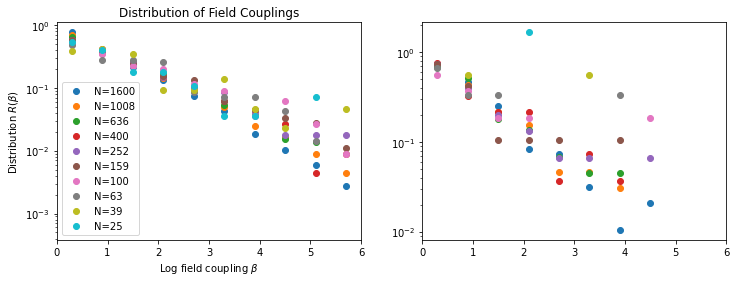

In [48]:
spins_left = L*L - measure_list
n_bins_h = 20
width_blk_list = []
width_bdry_list = []
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

for i,step in enumerate(spins_left[:-1]): 
    n_blk,bins_blk = np.histogram(beta_dist_list_blk[i], density=True, bins = n_bins_h, range=(0, 12))
    width_blk = bins_blk[1]-bins_blk[0]
    x_blk = (bins_blk[1:]-width_blk/2)
    y_blk = n_blk 

    popt, pcov = curve_fit(exponential_dist_norm, x_blk[:10], y_blk[:10])
    #plt.plot(x, exponential_dist_norm(x, *popt))
    width_blk_list.append(1/popt[0])
    
    n_bdry,bins_bdry = np.histogram(beta_dist_list_bdry[i], density=True, bins = n_bins_h, range=(0, 12))
    width_bdry = bins_bdry[1]-bins_bdry[0]
    x_bdry = (bins_bdry[1:]-width_bdry/2)
    y_bdry = n_bdry
    if i%2==0:
        axes[0].scatter(x_blk, y_blk, label="N="+str(step), marker='o')
        axes[1].scatter(x_bdry, y_bdry, label="N="+str(step), marker='o')

    popt, pcov = curve_fit(exponential_dist_norm, x_bdry[:15], y_bdry[:15])
    #plt.plot(x, exponential_dist_norm(x, *popt))
    width_bdry_list.append(1/popt[0])

axes[0].set_yscale('log')
axes[1].set_yscale('log')
axes[0].set_xlim(0, 6)
axes[1].set_xlim(0, 6)
#plt.ylim(1e-1, 1)

axes[0].set_xlabel(r"Log field coupling $\beta$")
axes[0].set_ylabel(r"Distribution $R(\beta)$")
axes[0].set_title("Distribution of Field Couplings")
#plt.yscale('log')
axes[0].legend()

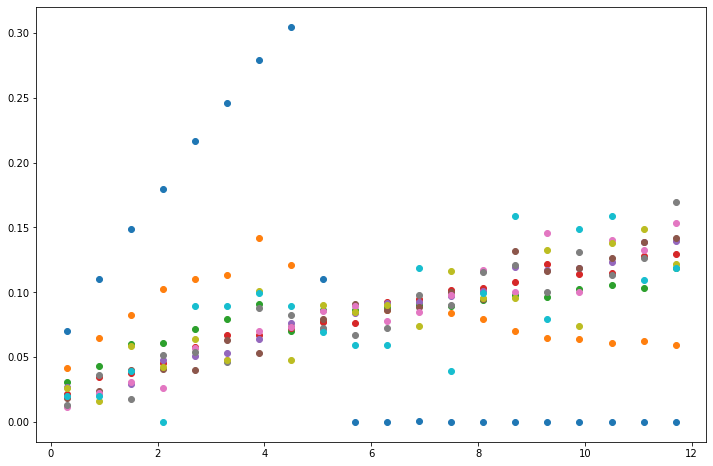

In [51]:
spins_left = L*L - measure_list
n_bins_h = 20
#fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
plt.figure(figsize=(12, 8))

for i,step in enumerate(spins_left[:-1]): 
    n_blk,bins_blk = np.histogram(zeta_dist_list_blk_blk[i], density=True, bins = n_bins_h, range=(0,12))
    width_blk = bins_blk[1]-bins_blk[0]
    x_blk = (bins_blk[1:]-width_blk/2)
    y_blk = n_blk 

    x_bdry = (bins_bdry[1:]-width_bdry/2)
    y_bdry = n_bdry
    if i%2==0:
        plt.scatter(x_blk, y_blk, label="N="+str(step), marker='o')
        #axes[1].scatter(x_bdry, y_bdry, label="N="+str(step), marker='o')


#axes[0].set_yscale('log')
#axes[1].set_yscale('log')
#axes[0].set_xlim(0, 6)
#axes[1].set_xlim(0, 6)
#plt.ylim(1e-1, 1)

#axes[0].set_xlabel(r"Log field coupling $\beta$")
#axes[0].set_ylabel(r"Distribution $R(\beta)$")
#axes[0].set_title("Distribution of Field Couplings")
#plt.yscale('log')
#axes[0].legend()

[0.16063379 3.39752951]
[ 0.62992224 27.07362692]


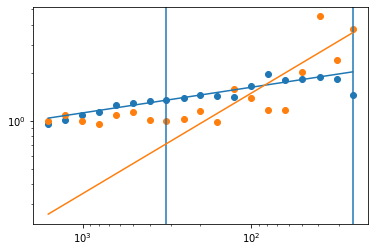

In [49]:
x = (L*L - measure_list)[:-1]
plt.scatter(x, width_blk_list)


start = -12
end = -1

plt.axvline(x=x[start])
plt.axvline(x = x[end])
popt, pcov = curve_fit(power_law_scale, x[start:end], width_blk_list[start:end])
plt.plot(x, power_law_scale(x, *popt))
print(popt)
plt.scatter(x, width_bdry_list)

popt, pcov = curve_fit(power_law_scale, x[start:end], width_bdry_list[start:end])
plt.plot(x, power_law_scale(x, *popt))
print(popt)
plt.gca().invert_xaxis()
plt.xscale('log')
plt.yscale('log')


In [27]:
zeta_stuff = test.zeta_ij_vals
bdry_dict = test.bdry_dict

In [44]:
plt.zeta_stuff[~bdry_dict,:][:,~bdry_dict].data

array([15.98739067,  2.49665185, 14.85636951,  6.00265908,  4.54372167,
        6.46073664,  5.39818659, 17.39120437, 18.32499664, 19.11438508,
       15.34536389,  7.71758915, 15.64459674, 22.29953912, 18.67042126,
       15.98739067, 18.5364014 ,  3.90687035, 21.65284436, 12.34440399,
       16.88383504,  7.67663364, 14.29777417, 14.35301491, 11.7544619 ,
       11.67230237, 21.8443557 , 17.16849328, 19.71202993, 30.0558348 ,
        2.49665185, 18.5364014 ,  8.99305041,  3.18645947,  7.11104499,
        1.85736957,  7.96550992, 11.62008416, 12.46167754, 14.51896982,
       17.91268722, 10.28491247, 18.21192006, 22.42832151, 21.23774458,
       14.85636951,  3.90687035,  8.99305041, 12.77239582, 17.11126255,
        6.50150659, 12.4434922 ,  3.05504537,  3.11028611,  4.11887745,
        9.33735697, 20.8452034 , 16.63117634, 12.24620869, 25.32604303,
        6.00265908, 21.65284436,  3.18645947, 12.77239582, 10.20917535,
        2.33359906, 11.06364028,  9.58755371, 14.92243475, 16.97

99